# Forcasting Credit Ratings of Corporations

### Introduction

The goal of this project is to use data analysis to gain insights and make predictions about the credit ratings of corporations. The project uses a set of training data obtained from Kaggle. The project will prepare the data and then load it into various machine learning models to make predictions. Then those models will be optimized and evaluated. 

### Data Preparation

In [120]:
# Import Dependencies 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from pyspark.sql.functions import col
import re
import numpy as np


The first steps are to create a Spark Session and load the data into a dataframe. The data can then be explored further. 

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/03/20 10:16:31 WARN Utils: Your hostname, Home-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en1)
24/03/20 10:16:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 10:16:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the CSV into a DataFrame.
from pyspark import SparkFiles
path = "../data/ratings.csv"

spark.sparkContext.addFile(path)
df = spark.read.csv(SparkFiles.get("ratings.csv"), sep=",", header=True)
df.show()

+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+------------------------+-----------------+------------+----------------+-----------+-------------+---------------------+-----------------+--------------+----------------------+-------------------------+----------------------+--------------------------+-----------------------------+------------------------+
|       Rating Agency|         Corporation|Rating|Rating Date|    CIK|Binary Rating|SIC Code|Sector|Ticker|Current Ratio|Long-term Debt / Capital|Debt/Equity Ratio|Gross Margin|Operating Margin|EBIT Margin|EBITDA Margin|Pre-Tax Profit Margin|Net Profit Margin|Asset Turnover|ROE - Return On Equity|Return On Tangible Equity|ROA - Return On Assets|ROI - Return On Investment|Operating Cash Flow Per Share|Free Cash Flow Per Share|
+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+-------------------

In [4]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView('ratings')

In [19]:
# View the Schema
df.printSchema()

root
 |-- Rating Agency: string (nullable = true)
 |-- Corporation: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Date: string (nullable = true)
 |-- CIK: string (nullable = true)
 |-- Binary Rating: string (nullable = true)
 |-- SIC Code: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Current Ratio: string (nullable = true)
 |-- Long-term Debt / Capital: string (nullable = true)
 |-- Debt/Equity Ratio: string (nullable = true)
 |-- Gross Margin: string (nullable = true)
 |-- Operating Margin: string (nullable = true)
 |-- EBIT Margin: string (nullable = true)
 |-- EBITDA Margin: string (nullable = true)
 |-- Pre-Tax Profit Margin: string (nullable = true)
 |-- Net Profit Margin: string (nullable = true)
 |-- Asset Turnover: string (nullable = true)
 |-- ROE - Return On Equity: string (nullable = true)
 |-- Return On Tangible Equity: string (nullable = true)
 |-- ROA - Return On Assets: string (null

In [28]:
query = """
SELECT COUNT(DISTINCT Corporation) AS DistinctCorporationsCount
FROM ratings
"""
spark.sql(query).show()  


+-------------------------+
|DistinctCorporationsCount|
+-------------------------+
|                     1377|
+-------------------------+



In [29]:
query = """
SELECT Corporation, COUNT(*) as Frequency
FROM ratings
GROUP BY Corporation
ORDER BY Frequency DESC
LIMIT 5
"""
spark.sql(query).show()


+--------------------+---------+
|         Corporation|Frequency|
+--------------------+---------+
|      TransDigm Inc.|       23|
|Mondelez Internat...|       23|
|Tenet Healthcare ...|       23|
|Duke Energy Corpo...|       22|
|               POSCO|       21|
+--------------------+---------+



In [33]:
query = """
SELECT `Rating Agency`, COUNT(*) AS AgencyCount
FROM ratings
GROUP BY `Rating Agency`
ORDER BY AgencyCount DESC
"""
spark.sql(query).show()


+--------------------+-----------+
|       Rating Agency|AgencyCount|
+--------------------+-----------+
|Egan-Jones Rating...|       2826|
|Standard & Poor's...|       2813|
|Moody's Investors...|       1636|
|       Fitch Ratings|        477|
|                DBRS|         26|
|Japan Credit Rati...|         22|
|HR Ratings de Mex...|          5|
+--------------------+-----------+



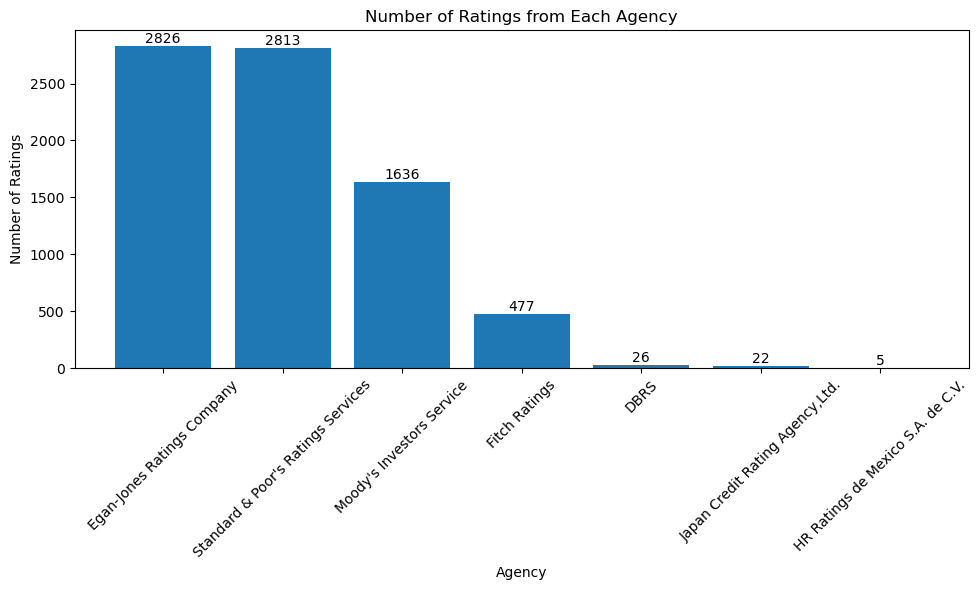

In [35]:
# Chart the count for rating agencies, storing the temporary results in a Pandas DF
result_df = spark.sql(query).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(result_df['Rating Agency'], result_df['AgencyCount'])
plt.title('Number of Ratings from Each Agency')
plt.xlabel('Agency')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/agency_count.png')
plt.show()




In [7]:
# Query the dataset to count the number of each rating

query = """
SELECT Rating, COUNT(*) as RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating ASC
"""
spark.sql(query).show(100)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



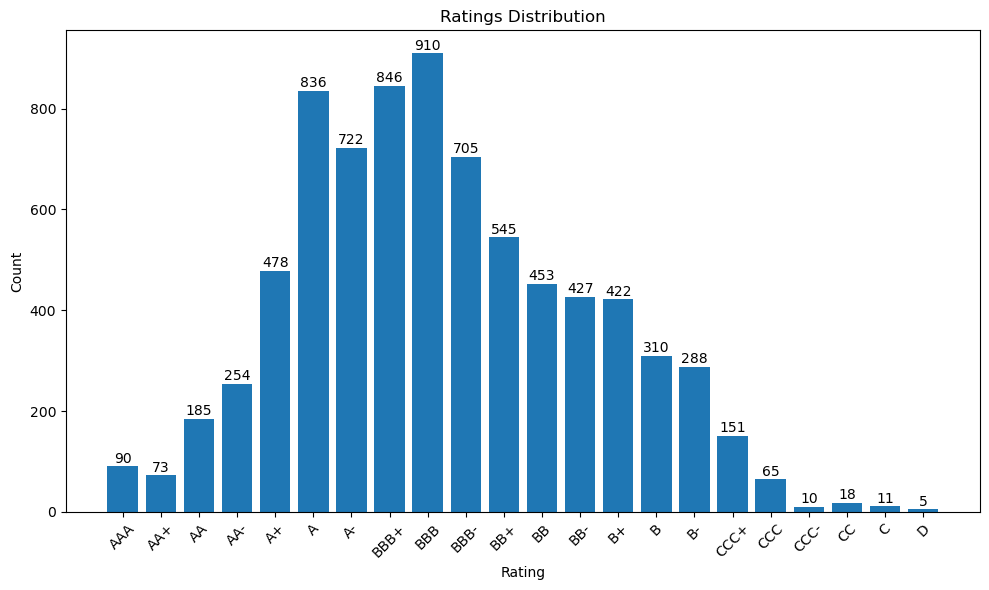

In [41]:
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating;
"""
result_df = spark.sql(query).toPandas()

result_df['RatingCount'] = pd.to_numeric(result_df['RatingCount'], errors='coerce').fillna(0).astype(int)

# Sort 
sorted_df = result_df.copy()
sorted_df['Rating'] = sorted_df['Rating'].astype(str)
sorted_df['Rating'] = pd.Categorical(sorted_df['Rating'], categories=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D'], ordered=True)
sorted_df = sorted_df.sort_values('Rating')
sorted_df = sorted_df.dropna(subset=['Rating'])

x_labels = sorted_df['Rating'].astype(str)
y_values = sorted_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Distribution')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings.png')
plt.show()


In [5]:
# Explore the data
query = """
SELECT YEAR(`Rating Date`) as YEAR, Rating, COUNT(Rating)
FROM ratings
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY YEAR(`Rating Date`), COUNT(Rating) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Rating|count(Rating)|
+----+------+-------------+
|2010|  BBB+|            6|
|2010|   BBB|            5|
|2010|    A-|            5|
|2010|  BBB-|            5|
|2010|     A|            5|
|2010|   AAA|            3|
|2010|   BB+|            3|
|2010|   BB-|            3|
|2010|    B+|            2|
|2010|    BB|            2|
|2010|   AA-|            1|
|2010|     B|            1|
|2011|   BBB|           41|
|2011|     A|           40|
|2011|  BBB-|           36|
|2011|  BBB+|           36|
|2011|   BB-|           23|
|2011|     B|           23|
|2011|    A-|           22|
|2011|   BB+|           22|
|2011|    BB|           16|
|2011|    A+|           10|
|2011|    AA|           10|
|2011|   AAA|           10|
|2011|  CCC+|            9|
|2011|    B+|            9|
|2011|    B-|            6|
|2011|   CCC|            6|
|2011|   AA-|            3|
|2011|    CC|            1|
|2011|     C|            1|
|2011|  CCC-|            1|
|2012|   BBB|       

In [45]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, COUNT(Rating) as RatingCount
FROM ratings
GROUP BY YEAR(`Rating Date`) 
ORDER BY YEAR(`Rating Date`), RatingCount DESC;
"""
spark.sql(query).show()

+----+-----------+
|YEAR|RatingCount|
+----+-----------+
|2010|         41|
|2011|        325|
|2012|       1071|
|2013|       1387|
|2014|       1944|
|2015|       2062|
|2016|        975|
+----+-----------+



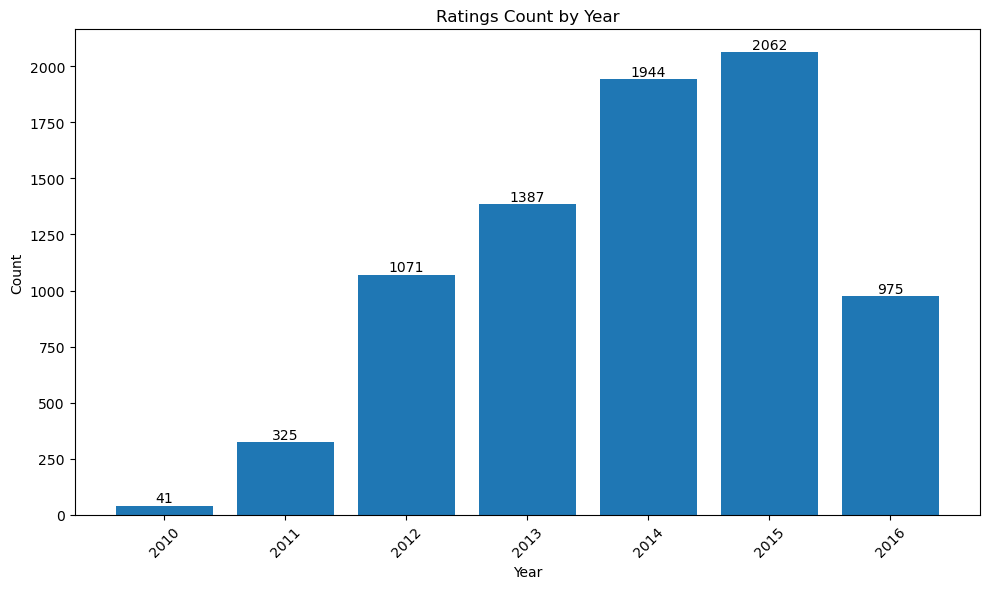

In [49]:
result_df = spark.sql(query).toPandas()

x_labels = result_df['YEAR']
y_values = result_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Ratings Count by Year')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings_by_Year.png')
plt.show()


In [51]:
query = """
SELECT Sector, COUNT(Rating) as RatingCount
FROM ratings
GROUP BY Sector 
ORDER BY RatingCount DESC;
"""
spark.sql(query).show()

+------+-----------+
|Sector|RatingCount|
+------+-----------+
| Other|       1251|
| Manuf|        981|
| BusEq|        958|
| Utils|        843|
| Shops|        786|
| Enrgy|        665|
|  Hlth|        625|
| NoDur|        567|
| Telcm|        386|
| Chems|        315|
| Durbl|        221|
| Money|        207|
+------+-----------+



In [61]:
query = """
SELECT `Binary Rating` AS Binary_Ratings, COUNT(*) AS Count
FROM ratings
GROUP BY `Binary Rating`
"""
spark.sql(query).show()

+--------------+-----+
|Binary_Ratings|Count|
+--------------+-----+
|             0| 2706|
|             1| 5099|
+--------------+-----+



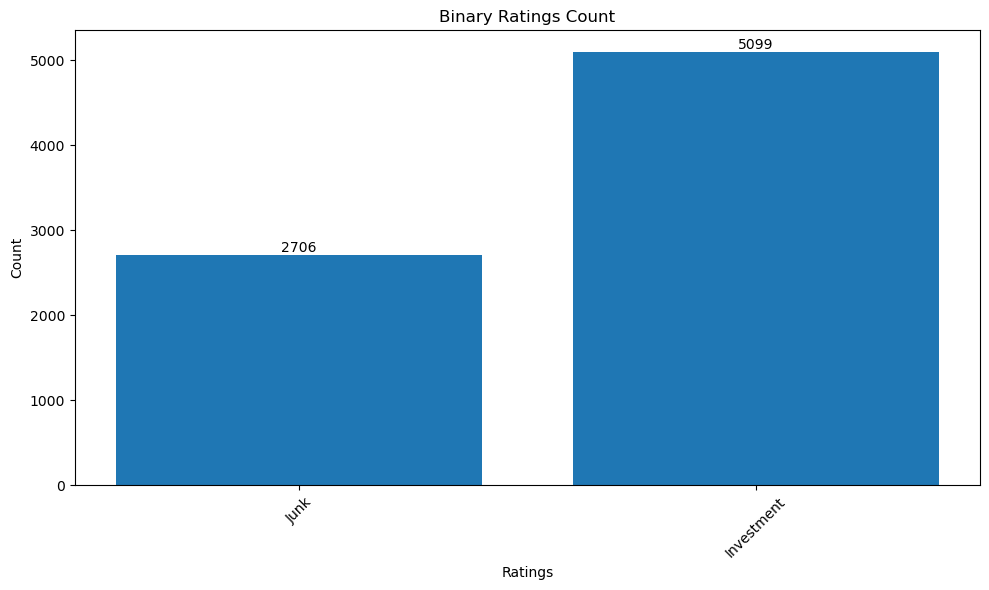

In [67]:
result_df = spark.sql(query).toPandas()

grades = {"0": "Junk", "1": "Investment"}
result_df['Binary_Ratings'] = result_df['Binary_Ratings'].map(grades)

x_labels = result_df['Binary_Ratings']
y_values = result_df['Count']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Binary Ratings Count')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Binary_Ratings.png')
plt.show()

In [70]:
# Create Graph of Counts by Ratings
# Query SparkDF and send to Pandas 
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show(100)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



In [53]:
# Ratings when the Binary Rating = 0
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '0' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show()

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



In [68]:
# Ratings when the Binary Rating = 1
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '1' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show()

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
+------+-----------+



The original dataset has normalized all the Ratings to match the S&P ratings, even ratings provided by other agencies. The dataset also has calculated a Binary Rating which matches the S&P Investment Grades and Junk Grades as well. These are considered industry standards. 

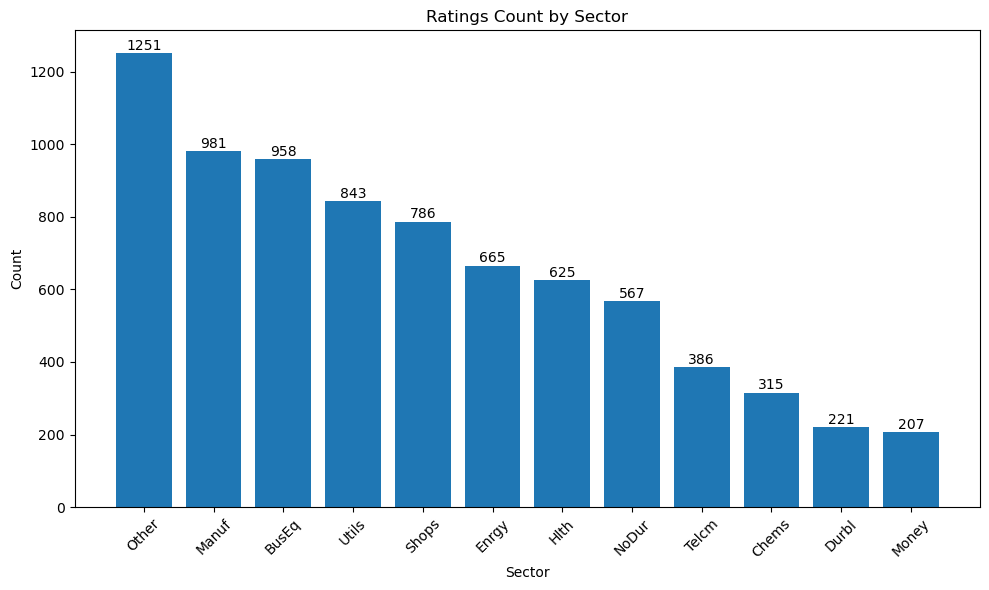

In [52]:
result_df = spark.sql(query).toPandas()

x_labels = result_df['Sector']
y_values = result_df['RatingCount']

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values)
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Ratings Count by Sector')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../img/exploration/Ratings_by_Sector.png')
plt.show()


In [101]:
# Average Values for "Investment Grade"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '1';
"""
spark.sql(query).show(500)



+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

In [102]:

result = spark.sql(query).collect()
first_row = result[0]
investment_grade_values = list(first_row.asDict().values())


In [103]:
# Average Values for Junk Grade
query2 = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '0';
"""
spark.sql(query).show(500)


+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

In [104]:

result = spark.sql(query2).collect()
first_row = result[0]
junk_grade_values = list(first_row.asDict().values())

In [110]:
metrics = [
    "Current Ratio", "Debt/Capital Ratio", "Debt/Equity Ratio", "Gross Margin",
    "Operating Margin", "EBIT Margin", "EBITDA Margin", "Pre-Tax Profit Margin",
    "Net Profit Margin", "Asset Turnover", "ROE - Return On Equity", "Return On Tangible Equity",
    "ROA - Return On Assets", "ROI - Return On Investment", "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share"]

difference = [i - j for i, j in zip(investment_grade_values, junk_grade_values)]


avg_values_df = pd.DataFrame({
    'Metric': metrics,
    'Investment Grade Avg': investment_grade_values,
    'Junk Grade Avg': junk_grade_values,
    'Difference in Avgs': difference
})

avg_values_df

,Metric,Investment Grade Avg,Junk Grade Avg,Difference in Avgs
0,Current Ratio,1.700042,2.352683,-0.652641
1,Debt/Capital Ratio,0.391542,0.568242,-0.176700
2,Debt/Equity Ratio,0.571551,-0.565460,1.137012
3,Gross Margin,45.044920,37.513898,7.531022
4,Operating Margin,15.263764,4.499001,10.764763
5,EBIT Margin,15.337796,4.506805,10.830992
6,EBITDA Margin,22.878268,14.782602,8.095666
7,Pre-Tax Profit Margin,13.208492,0.088973,13.119519
8,Net Profit Margin,9.631579,-0.855887,10.487466
9,Asset Turnover,0.852060,0.845665,0.006394


In [114]:
query = """
SELECT * FROM ratings
"""
result_df = spark.sql(query).toPandas()
result_df.head()


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.453,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.569,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.462,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [115]:
result_df = result_df.drop(columns=['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK', 'Binary Rating', 'Sector', 'Ticker', 'SIC Code'])
result_df.head()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,1.1507,0.4551,0.8847,77.623,19.4839,19.4839,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.453,1.9957,-0.1333
1,1.1129,0.0072,0.0073,43.6619,19.8327,19.8327,23.9379,20.8699,13.569,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,1.9276,0.2924,0.4255,11.9008,3.3173,3.3173,3.6338,3.0536,2.1418,2.462,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,0.8358,0.4708,0.9491,64.5096,18.4549,18.4549,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,1.2931,0.2644,0.4036,3.8385,1.3269,1.3269,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [127]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Current Ratio                  7805 non-null   object
 1   Long-term Debt / Capital       7805 non-null   object
 2   Debt/Equity Ratio              7805 non-null   object
 3   Gross Margin                   7805 non-null   object
 4   Operating Margin               7805 non-null   object
 5   EBIT Margin                    7805 non-null   object
 6   EBITDA Margin                  7805 non-null   object
 7   Pre-Tax Profit Margin          7805 non-null   object
 8   Net Profit Margin              7805 non-null   object
 9   Asset Turnover                 7805 non-null   object
 10  ROE - Return On Equity         7805 non-null   object
 11  Return On Tangible Equity      7805 non-null   object
 12  ROA - Return On Assets         7805 non-null   object
 13  ROI

In [130]:

result_df = result_df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Current Ratio                  7805 non-null   float64
 1   Long-term Debt / Capital       7805 non-null   float64
 2   Debt/Equity Ratio              7805 non-null   float64
 3   Gross Margin                   7805 non-null   float64
 4   Operating Margin               7805 non-null   float64
 5   EBIT Margin                    7805 non-null   float64
 6   EBITDA Margin                  7805 non-null   float64
 7   Pre-Tax Profit Margin          7805 non-null   float64
 8   Net Profit Margin              7805 non-null   float64
 9   Asset Turnover                 7805 non-null   float64
 10  ROE - Return On Equity         7805 non-null   float64
 11  Return On Tangible Equity      7805 non-null   float64
 12  ROA - Return On Assets         7805 non-null   f

In [143]:
general_aggregations = ['mean', 'std', 'var', 'min', 'max', 'median', 'sum', 'count']

detailed_stats = result_df.agg(general_aggregations)
detailed_stats

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
mean,1.926313,0.452804,0.177349,42.433909,11.531612,11.582683,20.071493,8.659944,5.995566,0.849843,15.950507,21.481589,4.575705,7.076084,0.479756,0.119491
std,1.921651,2.629158,34.456334,23.742020,25.469044,25.483934,24.380407,27.866408,24.055577,0.696204,230.592526,462.734075,9.229899,24.382027,6.050626,7.253660
var,3.692744,6.912471,1187.238958,563.683508,648.672205,649.430894,594.404233,776.536694,578.670780,0.484700,53172.912923,214122.824305,85.191044,594.483227,36.610071,52.615577
min,0.174900,-86.363600,-1473.098000,-87.684000,-461.787800,-461.787800,-360.816900,-476.010000,-414.824800,0.068400,-11258.210000,-14023.260000,-226.442500,-745.454500,-91.330200,-130.665800
max,34.076800,171.500000,194.375000,100.000000,93.993000,93.993000,286.493500,221.289400,219.390300,8.503900,7038.461000,9882.979000,114.716900,466.666700,282.192100,107.737700
median,1.496800,0.427200,0.752800,39.635400,12.120100,12.155800,18.304500,9.705100,6.938900,0.661200,12.500000,10.564100,4.767500,7.440800,0.237800,0.133500
sum,15034.872600,3534.132900,1384.205700,331196.658400,90004.232200,90402.837800,156658.006300,67590.864000,46795.389700,6633.023200,124493.705000,167663.800700,35713.380300,55228.837700,3744.495400,932.625900
count,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000


24/03/20 14:26:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 927650 ms exceeds timeout 120000 ms
24/03/20 14:26:59 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/20 14:27:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [15]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

# Import CSV into database
df = pd.read_csv('../data/ratings.csv')
conn.close()


In [16]:
df.head()

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [17]:
df.columns

Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

## Graphing Distribution and Outliers

In [18]:
# Creating filters for Poor Credit and Good Credit
df_rating_0 = df[df['Binary Rating'] == 0]
df_rating_1 = df[df['Binary Rating'] == 1]



In [49]:
# Function will show a box plot comparing the distribution of poor credit and good credit among various features. It will also show a distribution of the feature for both good and poor credit. 

def visualize_data(t, df_rating_0, df_rating_1, df):
    # Box plot
    plt.figure(figsize=(8, 6)) 
    box = plt.boxplot([df_rating_0[t], df_rating_1[t]],
                 notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

    # Set colors for each box
    colors = ['firebrick', 'royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    plt.xlabel(t)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {t} by Binary Ratings')
    plt.grid(True)
    # t2 removes slashes and spaces from the column name when using to save the charts
    t2 = re.sub(r'[ /]', '_', t)
    plt.savefig(f'../img/features/{t2}_box.png')
    plt.show()

    # Histogram
    plt.hist(df[t], color='darkseagreen')

    plt.xlabel(t)
    plt.ylabel('Frequency')
    plt.title(f'Total Distribution of {t}')
    plt.savefig(f'../img/features/{t2}_hist.png')
    plt.show()
    print(df[t].describe())


Processing column: Current Ratio


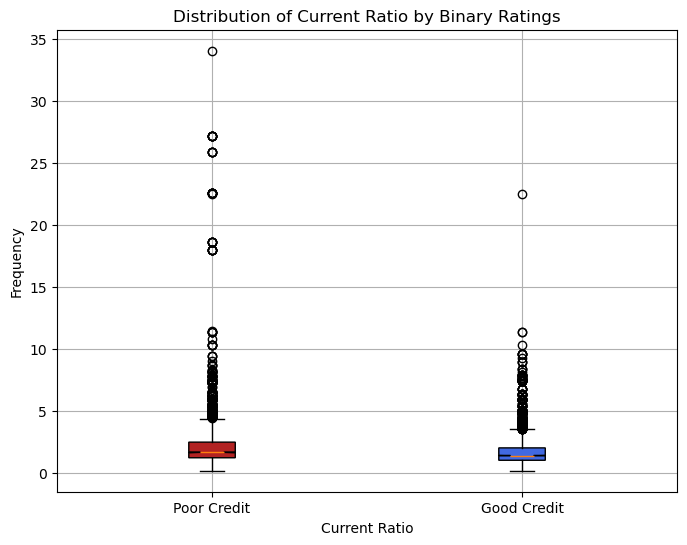

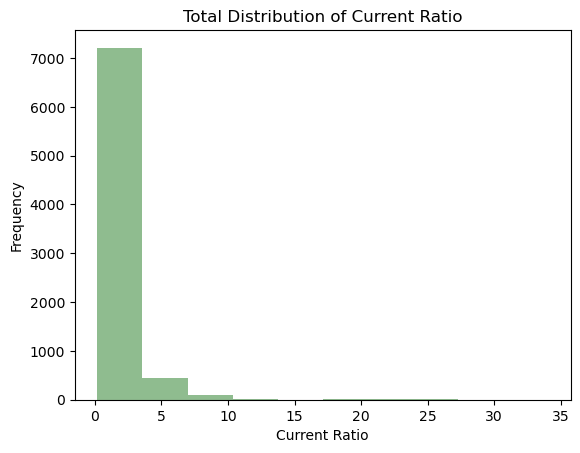

count    7805.000000
mean        1.926313
std         1.921651
min         0.174900
25%         1.077300
50%         1.496800
75%         2.161000
max        34.076800
Name: Current Ratio, dtype: float64
Processing column: Long-term Debt / Capital


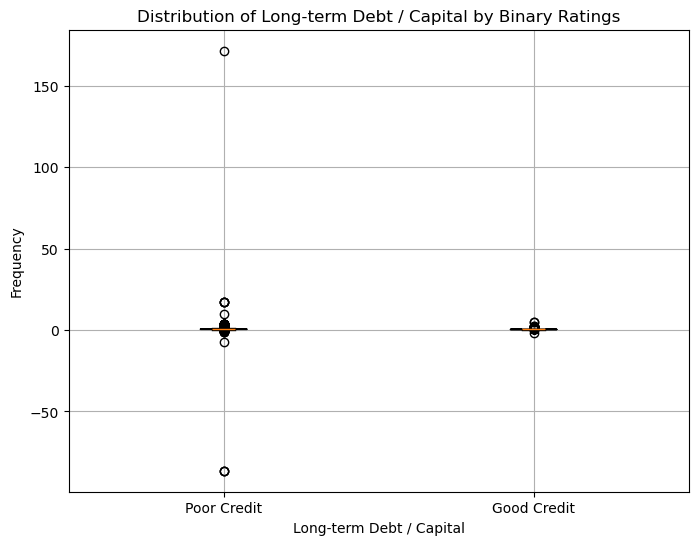

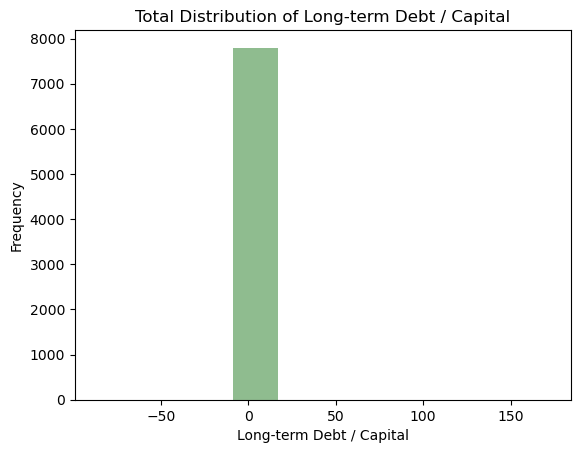

count    7805.000000
mean        0.452804
std         2.629158
min       -86.363600
25%         0.286500
50%         0.427200
75%         0.542200
max       171.500000
Name: Long-term Debt / Capital, dtype: float64
Processing column: Debt/Equity Ratio


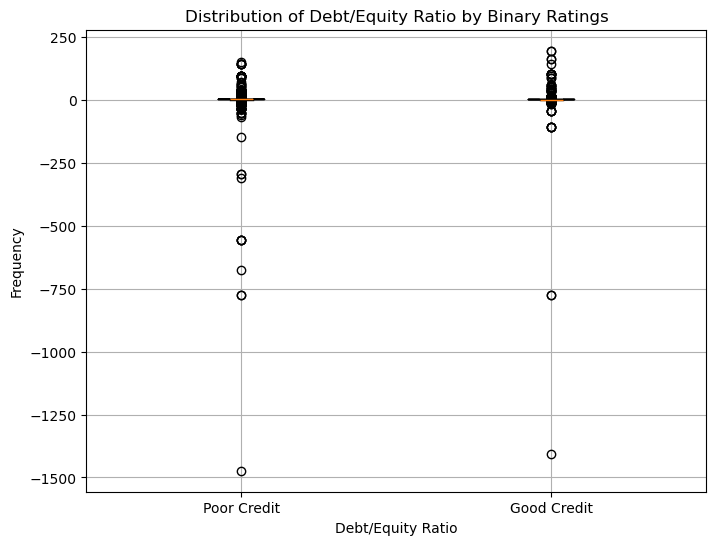

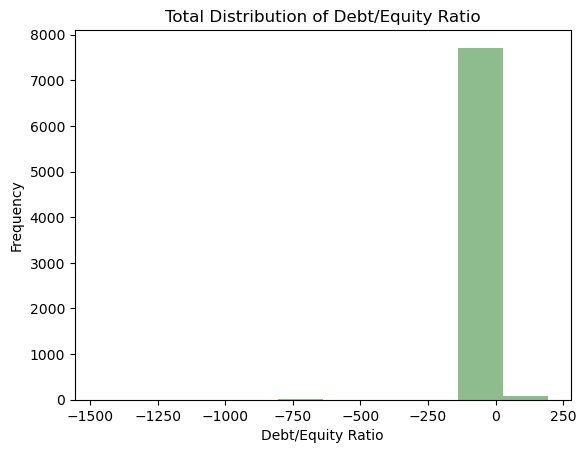

count    7805.000000
mean        0.177349
std        34.456334
min     -1473.098000
25%         0.419700
50%         0.752800
75%         1.211600
max       194.375000
Name: Debt/Equity Ratio, dtype: float64
Processing column: Gross Margin


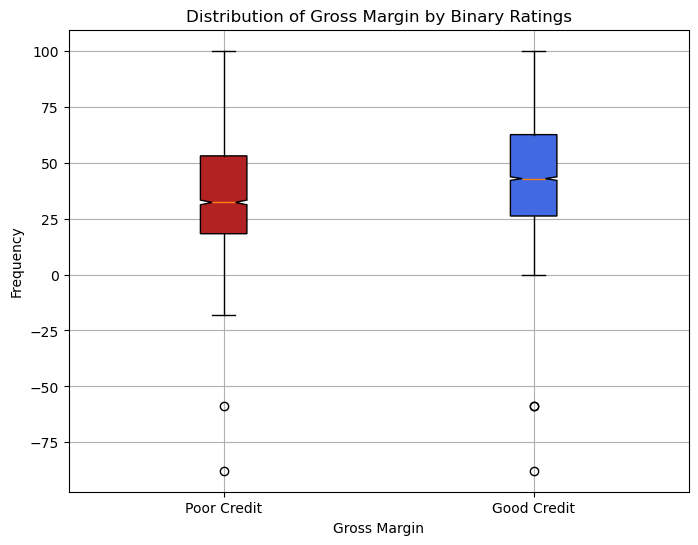

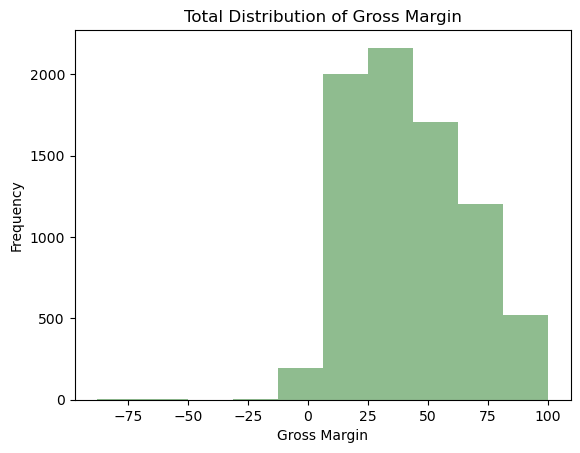

count    7805.000000
mean       42.433909
std        23.742020
min       -87.684000
25%        22.453900
50%        39.635400
75%        59.641700
max       100.000000
Name: Gross Margin, dtype: float64
Processing column: Operating Margin


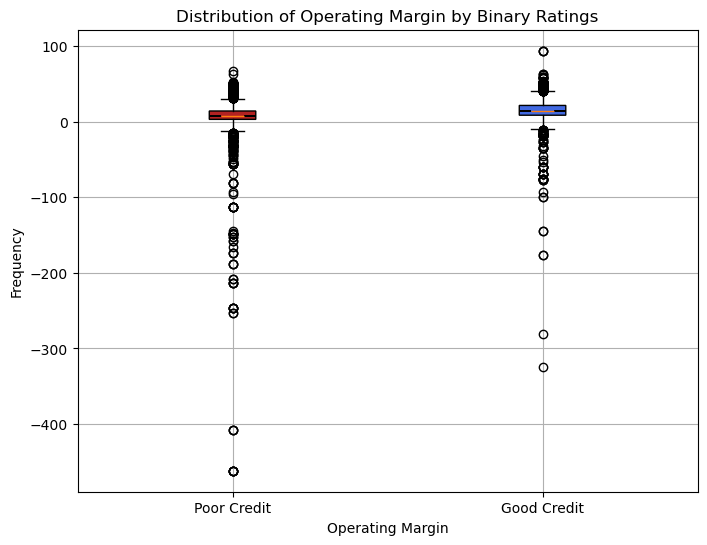

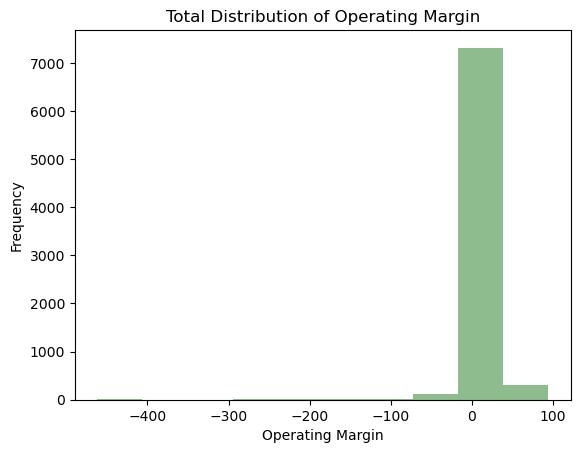

count    7805.000000
mean       11.531612
std        25.469044
min      -461.787800
25%         6.098200
50%        12.120100
75%        19.464600
max        93.993000
Name: Operating Margin, dtype: float64
Processing column: EBIT Margin


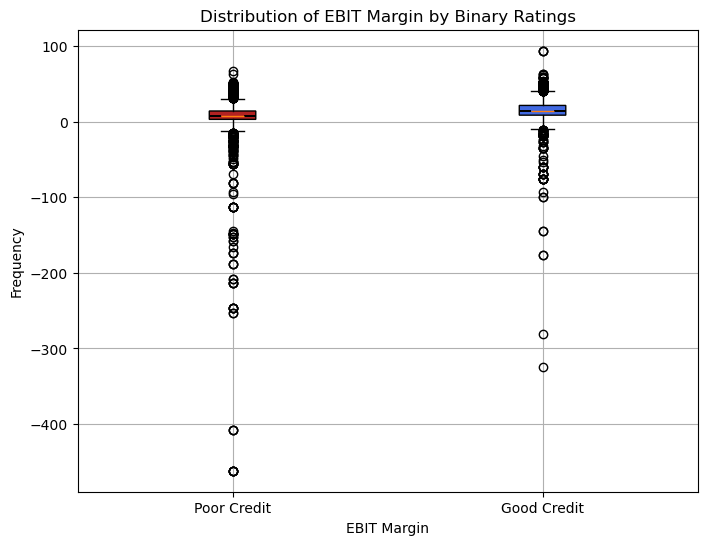

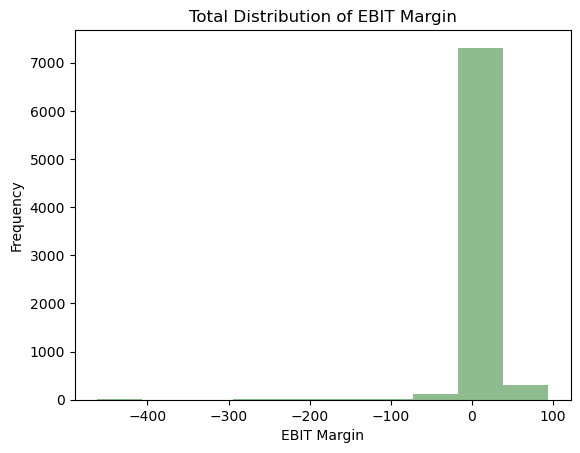

count    7805.000000
mean       11.582683
std        25.483934
min      -461.787800
25%         6.181100
50%        12.155800
75%        19.539900
max        93.993000
Name: EBIT Margin, dtype: float64
Processing column: EBITDA Margin


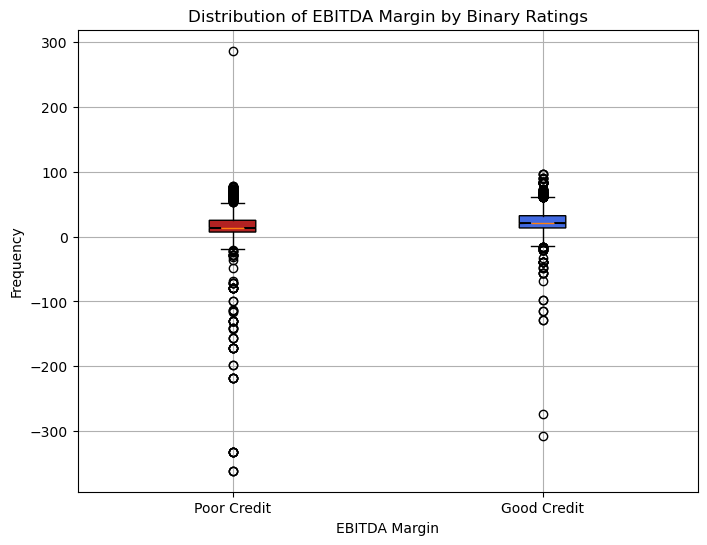

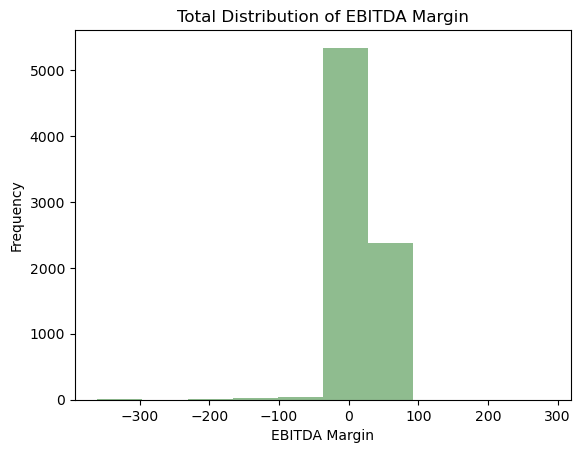

count    7805.000000
mean       20.071493
std        24.380407
min      -360.816900
25%        11.162100
50%        18.304500
75%        30.661600
max       286.493500
Name: EBITDA Margin, dtype: float64
Processing column: Pre-Tax Profit Margin


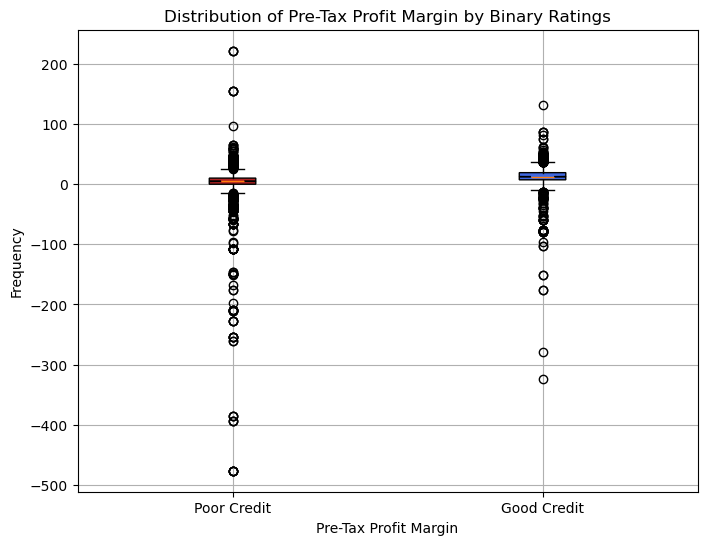

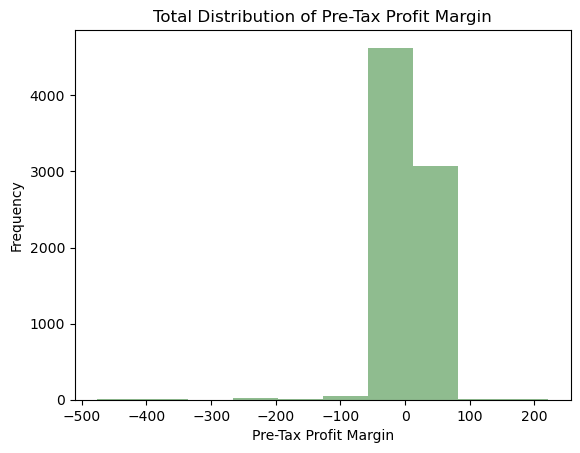

count    7805.000000
mean        8.659944
std        27.866408
min      -476.010000
25%         4.008700
50%         9.705100
75%        16.676900
max       221.289400
Name: Pre-Tax Profit Margin, dtype: float64
Processing column: Net Profit Margin


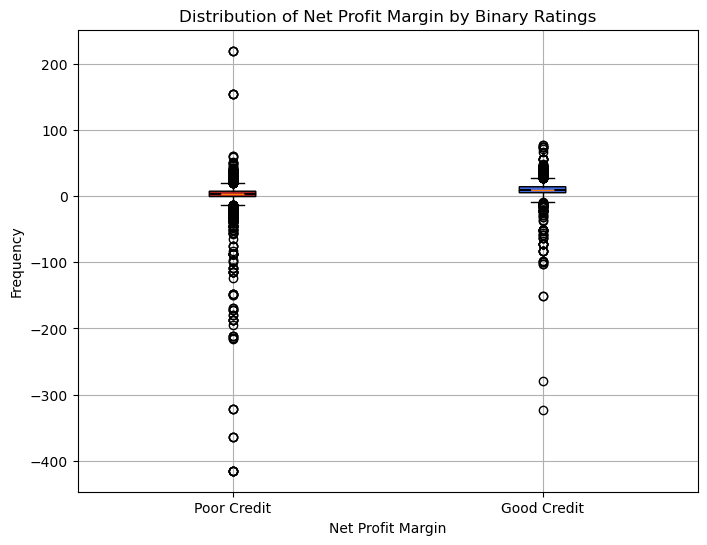

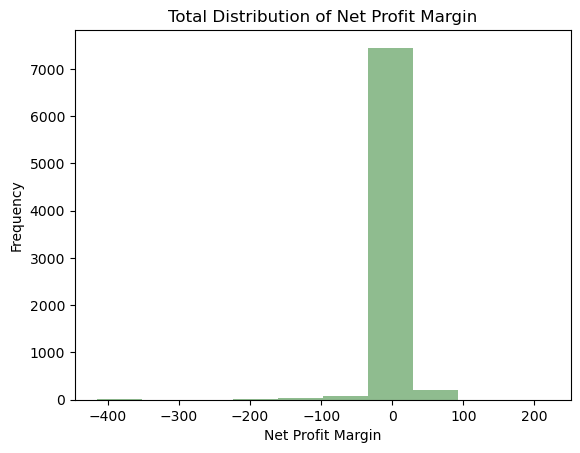

count    7805.000000
mean        5.995566
std        24.055577
min      -414.824800
25%         2.637100
50%         6.938900
75%        12.366700
max       219.390300
Name: Net Profit Margin, dtype: float64
Processing column: Asset Turnover


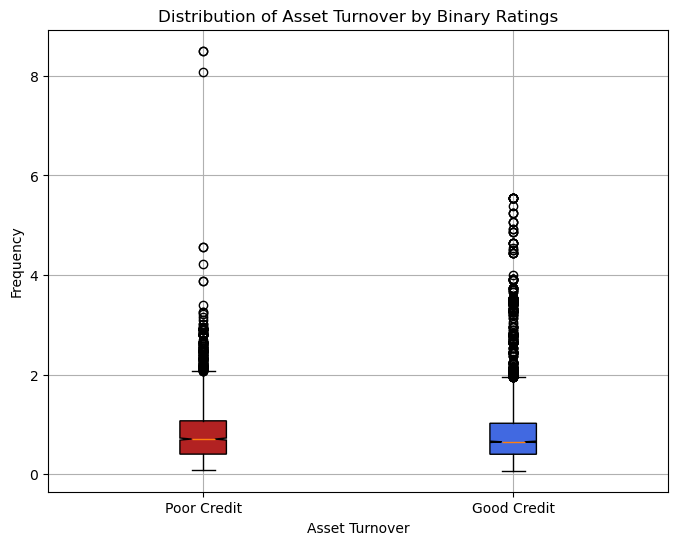

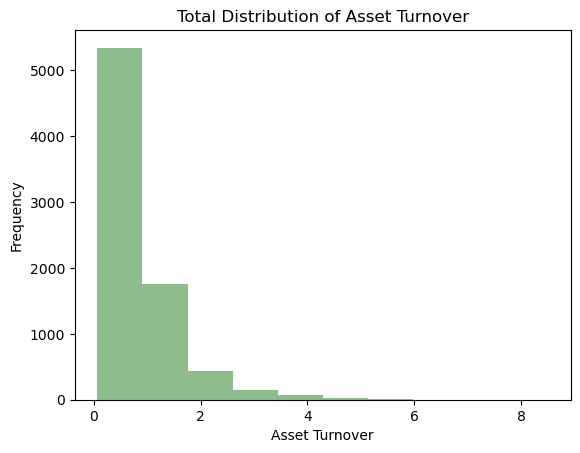

count    7805.000000
mean        0.849843
std         0.696204
min         0.068400
25%         0.399500
50%         0.661200
75%         1.038800
max         8.503900
Name: Asset Turnover, dtype: float64
Processing column: ROE - Return On Equity


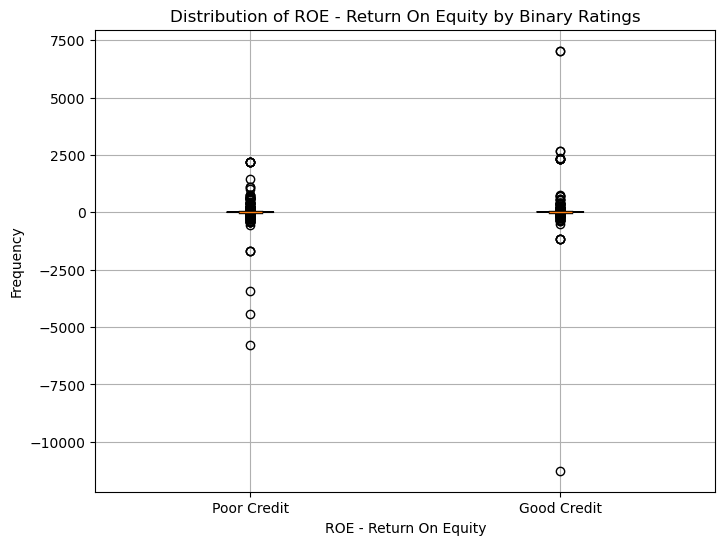

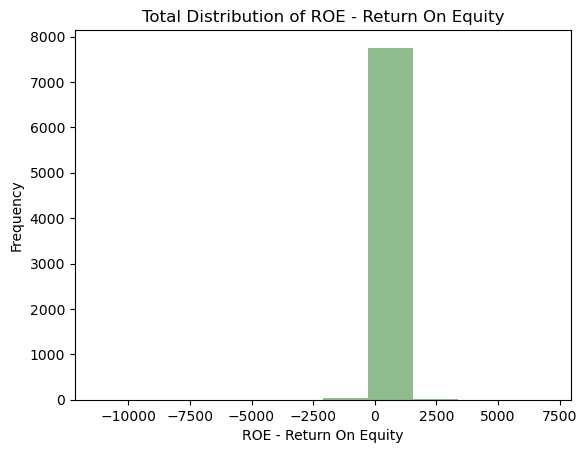

count     7805.000000
mean        15.950507
std        230.592526
min     -11258.210000
25%          6.022800
50%         12.500000
75%         20.515700
max       7038.461000
Name: ROE - Return On Equity, dtype: float64
Processing column: Return On Tangible Equity


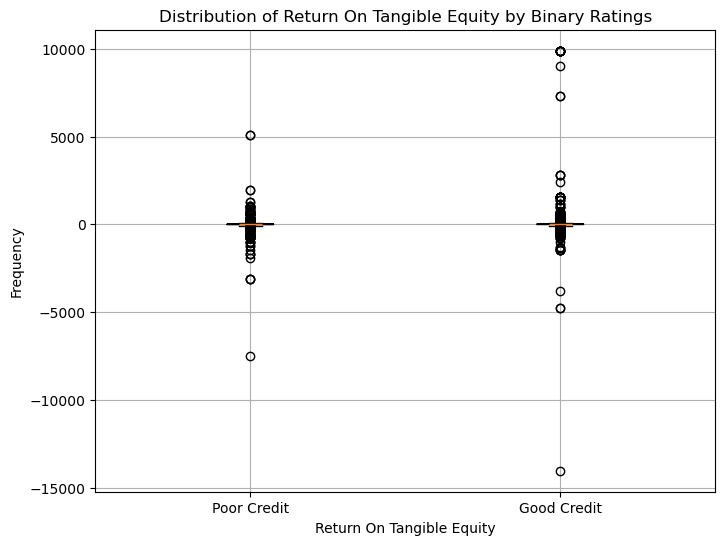

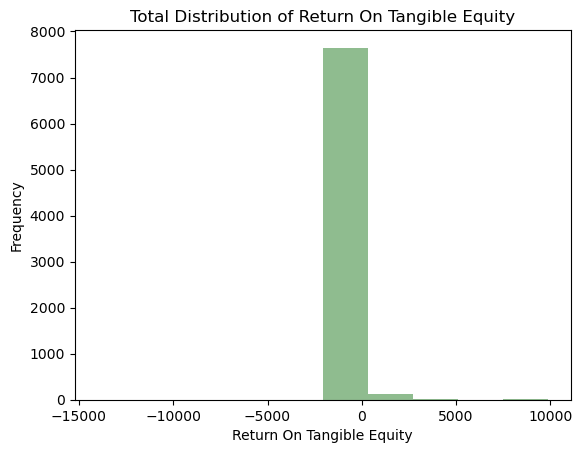

count     7805.000000
mean        21.481589
std        462.734075
min     -14023.260000
25%        -12.233900
50%         10.564100
75%         26.894100
max       9882.979000
Name: Return On Tangible Equity, dtype: float64
Processing column: ROA - Return On Assets


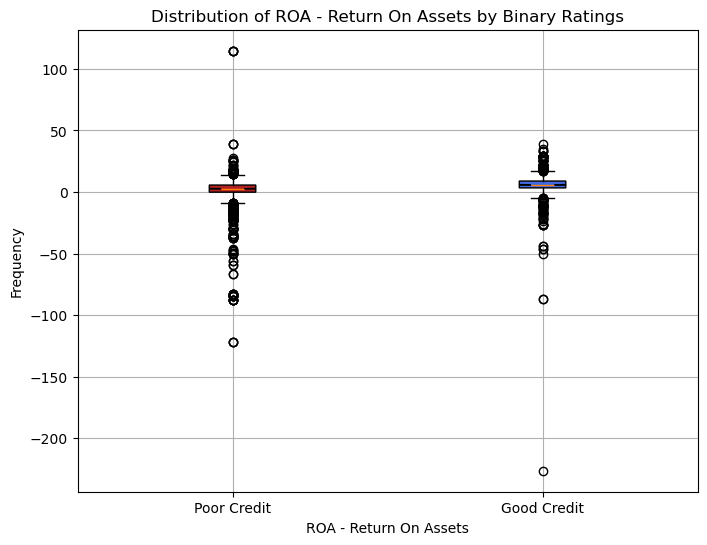

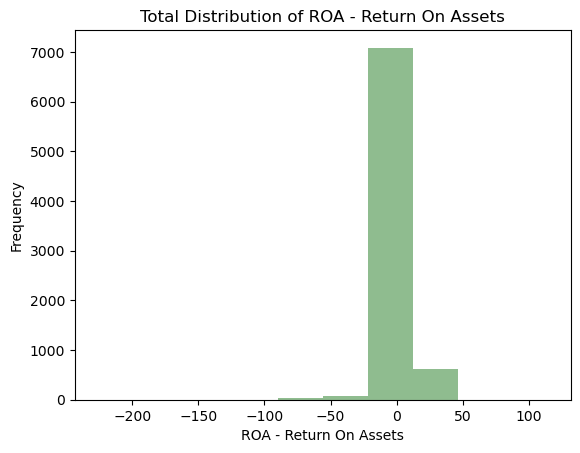

count    7805.000000
mean        4.575705
std         9.229899
min      -226.442500
25%         2.391900
50%         4.767500
75%         7.881300
max       114.716900
Name: ROA - Return On Assets, dtype: float64
Processing column: ROI - Return On Investment


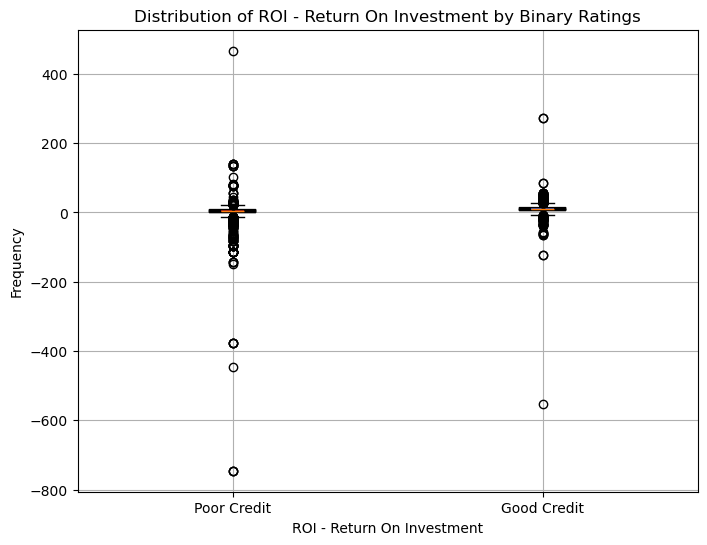

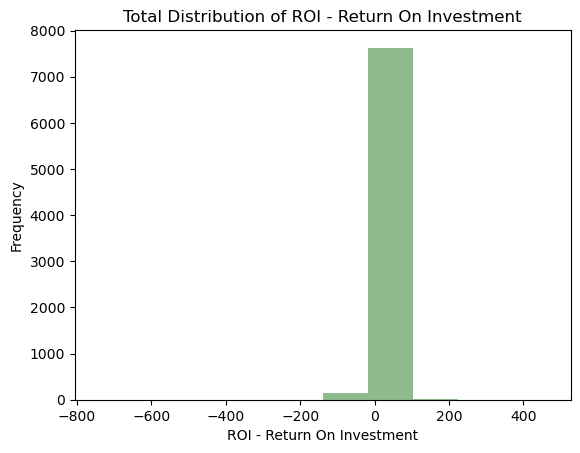

count    7805.000000
mean        7.076084
std        24.382027
min      -745.454500
25%         3.692600
50%         7.440800
75%        12.515100
max       466.666700
Name: ROI - Return On Investment, dtype: float64
Processing column: Operating Cash Flow Per Share


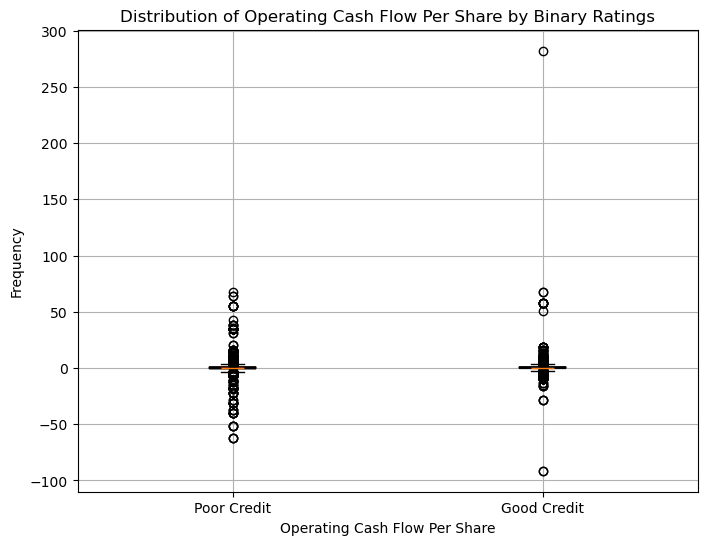

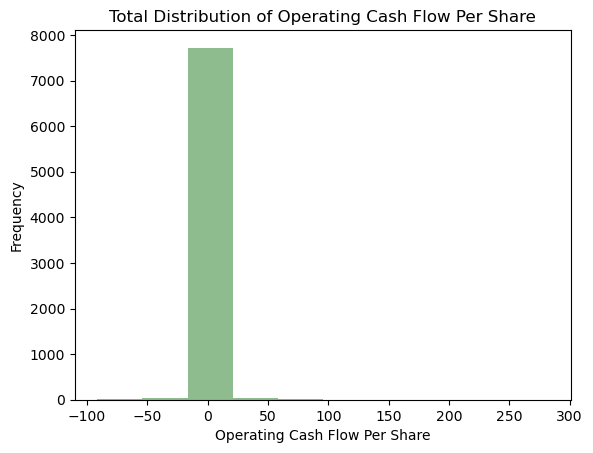

count    7805.000000
mean        0.479756
std         6.050626
min       -91.330200
25%        -0.448500
50%         0.237800
75%         1.088800
max       282.192100
Name: Operating Cash Flow Per Share, dtype: float64
Processing column: Free Cash Flow Per Share


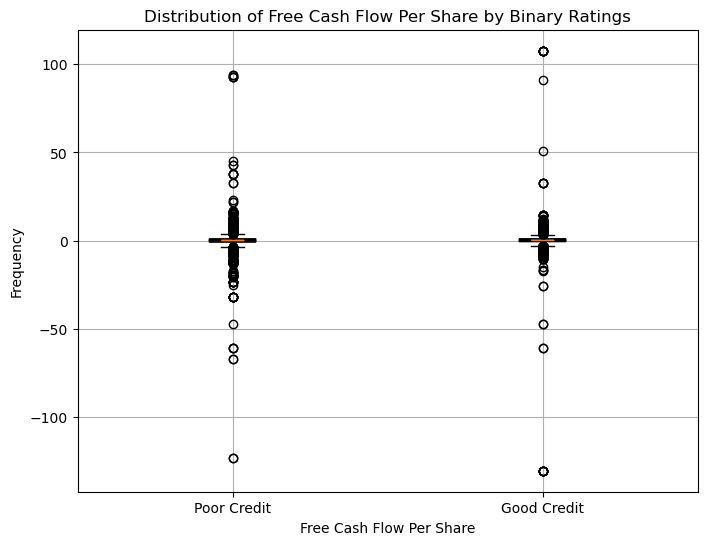

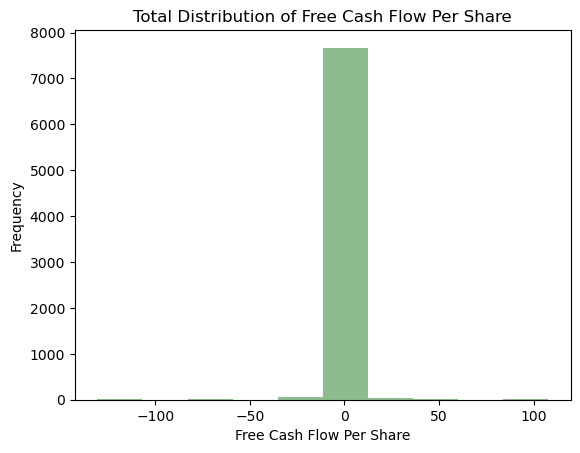

count    7805.000000
mean        0.119491
std         7.253660
min      -130.665800
25%        -0.723700
50%         0.133500
75%         0.997800
max       107.737700
Name: Free Cash Flow Per Share, dtype: float64


24/03/19 13:37:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1041160 ms exceeds timeout 120000 ms
24/03/19 13:37:55 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/19 13:37:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

In [50]:
col_list = ['Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

for t in col_list:
    print(f"Processing column: {t}")
    visualize_data(t, df_rating_0, df_rating_1, df)

In [22]:
df.head(2)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132


In [23]:
df['Sector'].value_counts()

Sector
Other    1251
Manuf     981
BusEq     958
Utils     843
Shops     786
Enrgy     665
Hlth      625
NoDur     567
Telcm     386
Chems     315
Durbl     221
Money     207
Name: count, dtype: int64

In [24]:
df['Sector'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7805 entries, 0 to 7804
Series name: Sector
Non-Null Count  Dtype 
--------------  ----- 
7805 non-null   object
dtypes: object(1)
memory usage: 61.1+ KB


In [35]:

def sector_chart(sector):
    filtered_df_1 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()

    plt.bar(['Poor Credit', 'Good Credit'], [ratingCount0, ratingCount1], color=['firebrick', 'royalblue'])
    plt.xlabel('Credit Rating')
    plt.ylabel('Count')
    plt.title(f'Counts of Credit Ratings in the {sector} sector')
    plt.savefig(f'../img/sectors/{sector}_bar.png')
    plt.show()

Processing sector: Utils


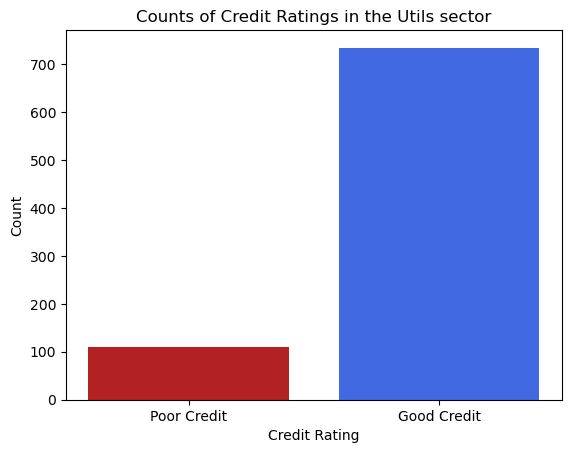

Processing sector: BusEq


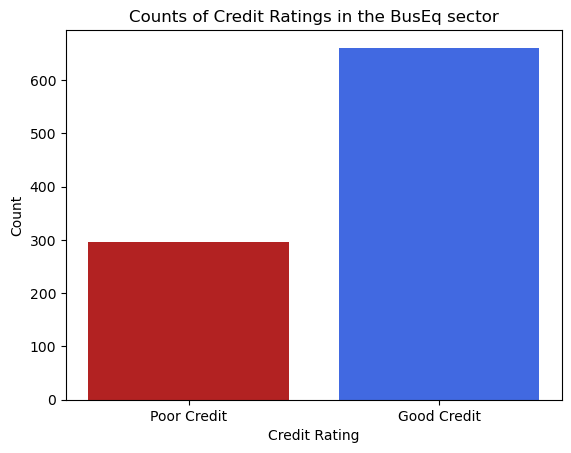

Processing sector: Shops


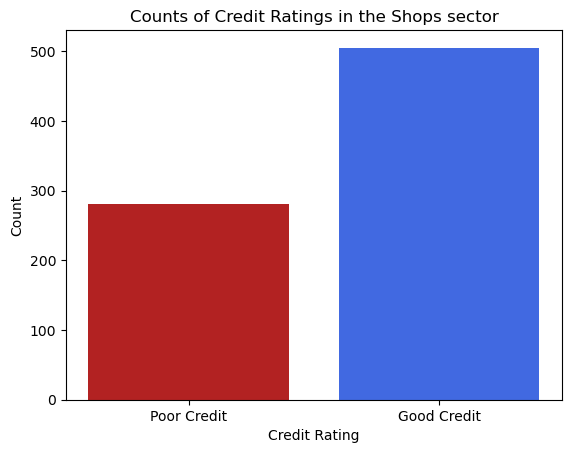

Processing sector: Manuf


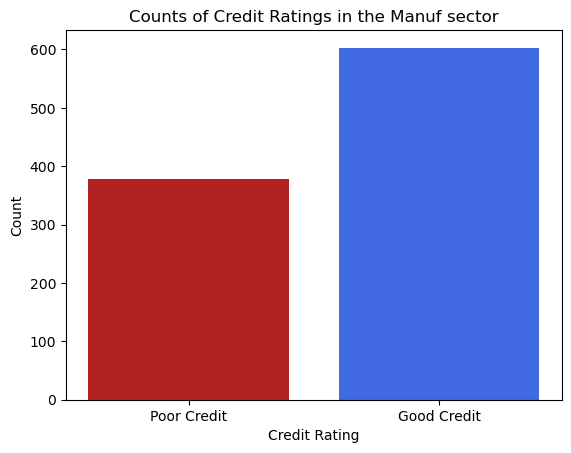

Processing sector: NoDur


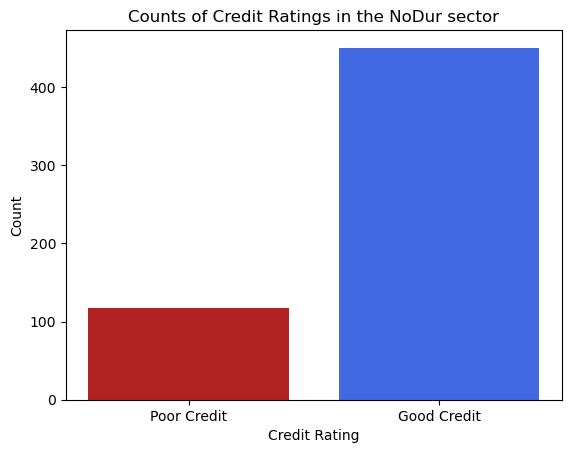

Processing sector: Other


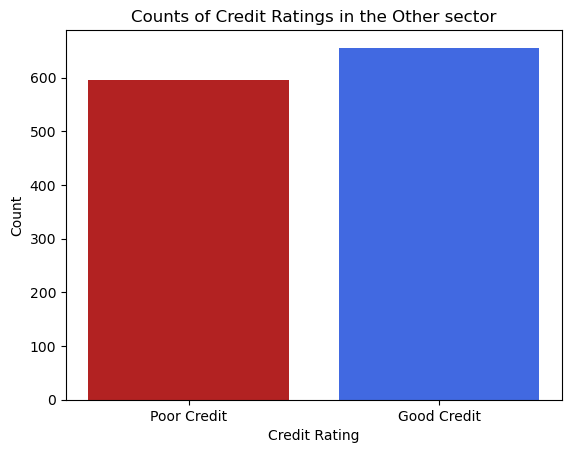

Processing sector: Chems


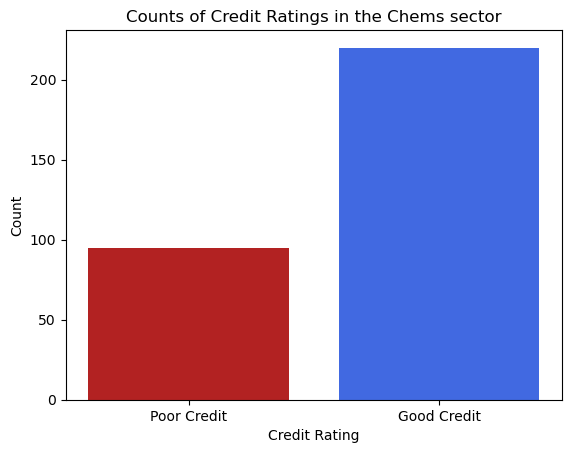

Processing sector: Telcm


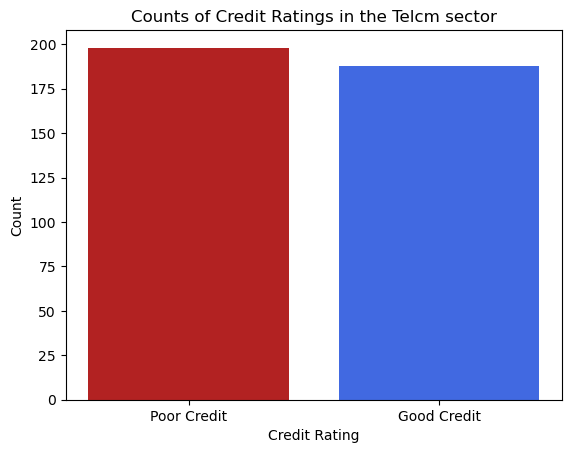

Processing sector: Hlth


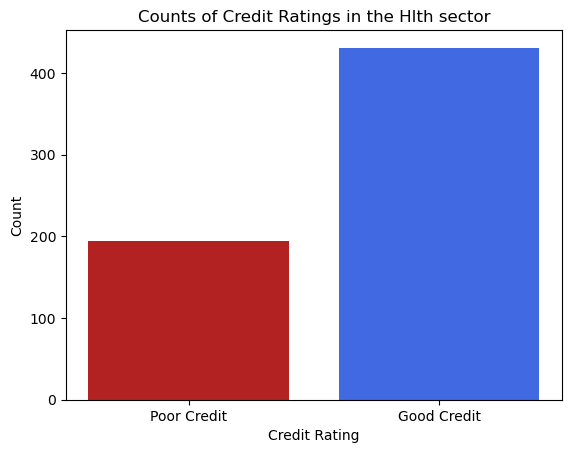

Processing sector: Money


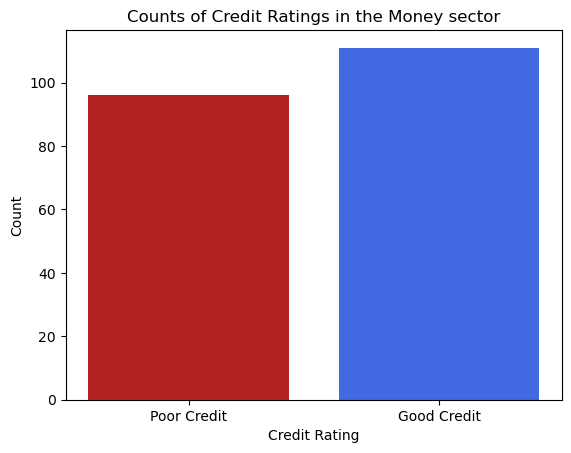

Processing sector: Durbl


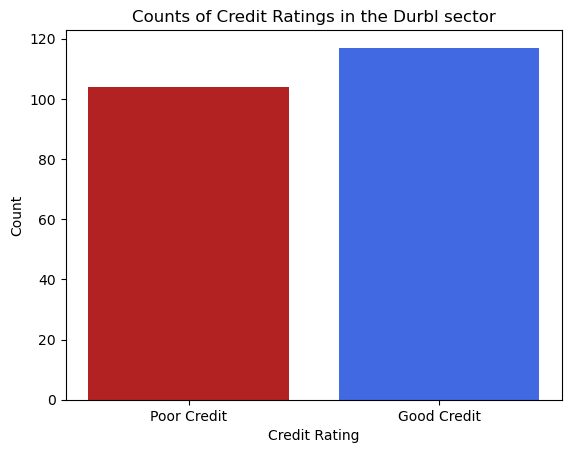

Processing sector: Enrgy


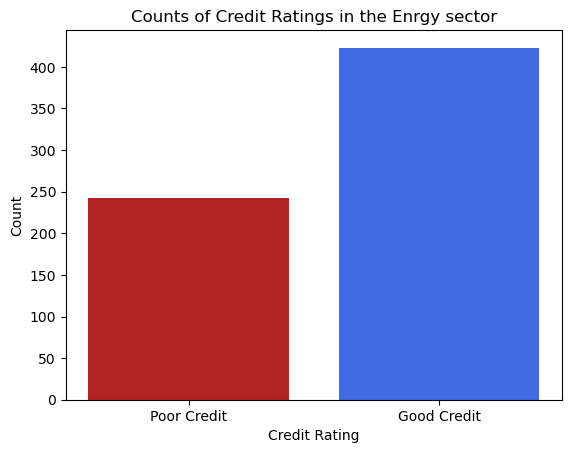

In [36]:
for sector in df['Sector'].unique():
    print(f"Processing sector: {sector}")
    sector_chart(sector)

In [ ]:
# Sector information appears useful so converting to numeric data
secDict = {"Other": 1, "Manuf": 2, "BusEq": 3, "Utils": 4, "Shops": 5, "Enrgy": 6, "Hlth": 7, "NoDur": 8, "Telcm": 9, "Chems": 10, "Durbl": 11, "Money": 12}
df['Sector'] = df['Sector'].replace(secDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
6791,Standard & Poor's Ratings Services,Wolverine World Wide Inc.,BBB-,2015-07-17,110471,1,3140.0,8,WWW,3.0590,...,10.2568,6.5735,4.8205,1.1025,14.2751,-44.1332,5.3464,7.4717,1.0974,1.1910
5605,Moody's Investors Service,"Greif, Inc.",BB-,2015-08-25,43920,0,2650.0,2,GEF,1.3378,...,9.5563,3.7272,-0.1675,1.1559,3.6707,25.4391,1.2243,1.9432,0.2305,-0.6304
4585,Fitch Ratings,Thermo Fisher Scientific Inc.,BBB,2014-11-17,97745,1,3826.0,3,TMO,2.3097,...,19.7108,10.1472,9.4157,0.4558,8.1372,-26.1388,4.5852,5.5939,1.1688,1.0009
4287,Moody's Investors Service,Precision Drilling Corporation,BB+,2014-05-28,1013605,0,1381.0,6,PDS,1.6984,...,32.8702,1.3561,2.5657,0.4746,10.7196,12.5496,5.4125,6.8657,7.0073,-1.6075
4723,Egan-Jones Ratings Company,WILLIAMS COMPANIES INC.,BB+,2014-08-07,107263,0,4922.0,4,WMB,0.8487,...,31.9242,15.7434,6.2682,0.2527,7.6113,10.2398,2.5017,3.3491,0.2925,-0.8579
5828,Standard & Poor's Ratings Services,Koppers Holdings Inc.,B+,2015-01-14,1315257,0,2860.0,10,KOP,1.8531,...,4.9646,-0.3794,-2.0836,1.2018,-47.6758,12.0846,-3.0914,-4.4919,-3.9150,-4.5079
1054,Standard & Poor's Ratings Services,National Grid North America Inc.,A,2012-02-14,1004315,1,4911.0,4,NGG,0.9263,...,34.7905,18.2946,15.0805,0.3091,19.4976,46.6306,3.8109,6.0318,-3.3116,-0.3809
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,4,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
3356,Egan-Jones Ratings Company,DANAHER CORPORATION,AA-,2014-10-17,313616,1,3826.0,3,DHR,1.8040,...,21.9322,16.4881,13.1005,0.5543,12.0484,-84.4679,6.9801,9.4344,1.0436,0.8779
4684,Egan-Jones Ratings Company,VULCAN MATERIALS COMPANY,BB,2014-08-29,1396009,0,1400.0,1,VMC,2.2570,...,16.2326,-4.6904,-2.0486,0.3159,-1.4338,296.5242,-0.6636,-0.8577,0.5314,1.0938


In [ ]:
df['Rating Agency'].value_counts()

Rating Agency
Egan-Jones Ratings Company            2826
Standard & Poor's Ratings Services    2813
Moody's Investors Service             1636
Fitch Ratings                          477
DBRS                                    26
Japan Credit Rating Agency,Ltd.         22
HR Ratings de Mexico S.A. de C.V.        5
Name: count, dtype: int64

In [ ]:
test= "Standard & Poor's Ratings Services"
t3 = test[:2]
print(t3)

St


In [37]:
def agency_Chart(agency, a2):
    filtered_df_1 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()
    
    plt.bar(['Poor Credit', 'Good Credit'], [ratingCount0, ratingCount1], color=['firebrick', 'royalblue'])
    plt.xlabel('Agency Name')
    plt.ylabel('Count')
    plt.title(f'Counts of {agency} by Ratings')

    plt.savefig(f'../img/agencies/{a2}_bar.png')
    plt.show()

Processing agency: Standard & Poor's Ratings Services
a2: StandardPoorsRatingsServices


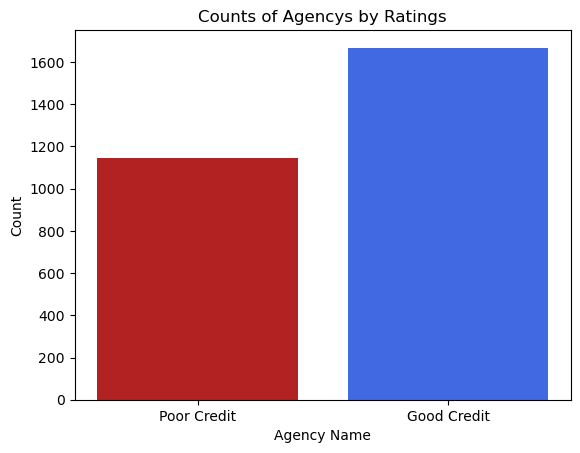

Processing agency: DBRS
a2: DBRS


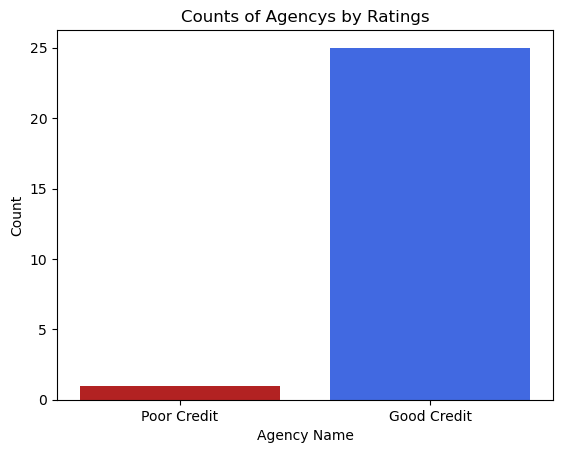

Processing agency: Moody's Investors Service
a2: MoodysInvestorsService


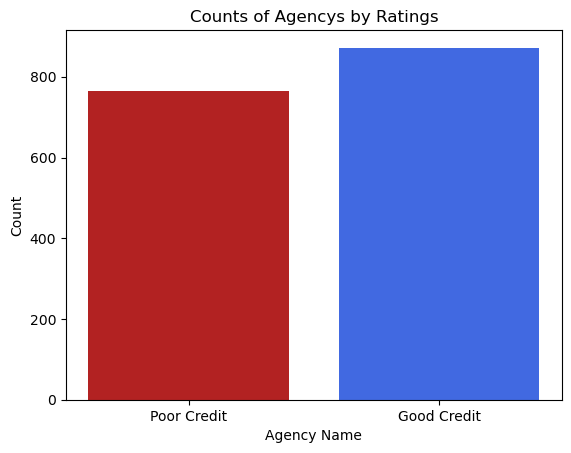

Processing agency: Fitch Ratings
a2: FitchRatings


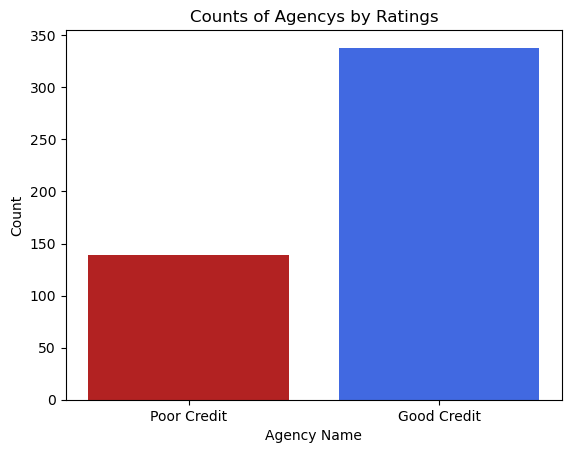

Processing agency: Japan Credit Rating Agency,Ltd.
a2: JapanCreditRatingAgencyLtd


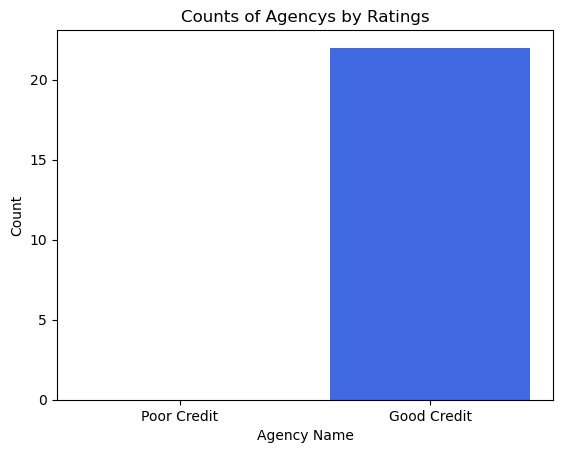

Processing agency: HR Ratings de Mexico S.A. de C.V.
a2: HRRatingsdeMexicoSAdeCV


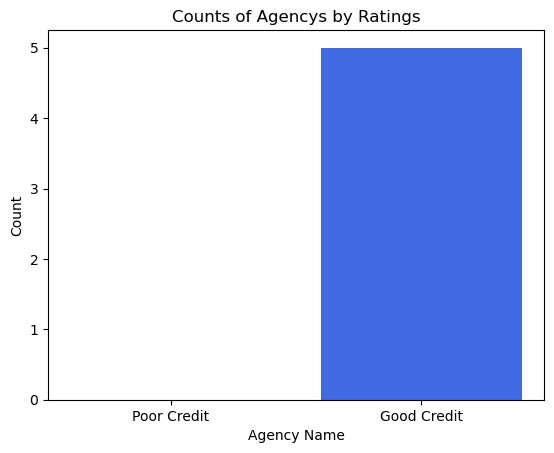

Processing agency: Egan-Jones Ratings Company
a2: EganJonesRatingsCompany


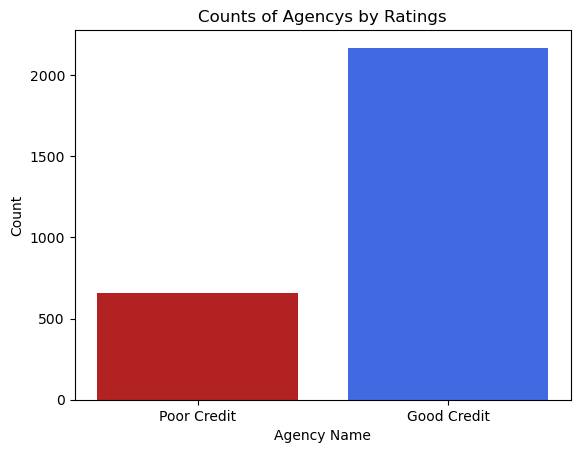

In [38]:
for agency in df['Rating Agency'].unique():
    a2 = re.sub(r'[^\w]', '', agency)
    print(f"Processing agency: {agency}")
    print(f'a2: {a2}')

    agency_Chart(agency, a2)

In [ ]:
df['Rating Agency'].value_counts()

Rating Agency
Egan-Jones Ratings Company            2826
Standard & Poor's Ratings Services    2813
Moody's Investors Service             1636
Fitch Ratings                          477
DBRS                                    26
Japan Credit Rating Agency,Ltd.         22
HR Ratings de Mexico S.A. de C.V.        5
Name: count, dtype: int64

In [ ]:
agency_counts = df['Rating Agency'].value_counts()

# Create a dictionary with incremental numeric values
agencyDict = {}
count = 1
for agency in agency_counts.index:
    agencyDict[agency] = count
    count += 1

df['Rating Agency'] = df['Rating Agency'].replace(agencyDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
1692,1,CROWN CASTLE INTERNATIONAL,BB,2013-10-21,1051470,0,6798.0,12,CCI,1.4900,...,66.3246,8.8456,7.2876,0.1928,7.1835,-11.2678,1.6260,1.7963,0.1460,-0.2755
5338,1,"D.R. HORTON, INC",BBB,2015-11-11,882184,1,1531.0,1,DHI,6.8080,...,10.7354,10.3788,6.9355,0.9707,12.7337,12.9248,6.7321,7.7337,3.6981,3.9712
6110,2,NXP Semiconductors N.V.,BB-,2015-10-26,1413447,0,3674.0,3,NXPI,1.7536,...,24.1952,7.8297,7.2274,0.7466,26.8435,-26.4837,6.4351,8.5975,0.5829,0.7672
6412,1,SHERWIN-WILLIAMS COMPANY,A+,2015-11-03,89800,1,2851.0,10,SHW,0.9571,...,13.5334,11.3053,7.7801,1.9528,86.8954,-191.9915,15.1928,40.9894,0.1454,0.0076
1708,2,Calumet Specialty Products Partners LP,B,2013-03-29,1340122,0,2911.0,6,CLMT,1.7541,...,8.3933,4.4339,4.1870,2.0672,23.9381,40.6763,9.1300,11.7375,5.3308,5.4943
7791,2,Xylem Inc.,A,2016-09-23,1524472,1,3561.0,2,XYL,2.2857,...,15.4494,10.7508,8.6057,0.8103,15.8439,1531.8180,6.9729,10.1445,0.5168,0.5266
3162,1,CENTURY ALUMINUM COMPANY,B,2014-05-28,949157,0,3350.0,2,CENX,1.9013,...,-0.0699,-2.7397,-2.7720,0.8034,-4.0200,-4.0200,-2.2270,-3.2267,-0.1970,-0.6057
2442,3,"Post Holdings, Inc.",B+,2013-11-13,1530950,0,2015.0,8,POST,4.5760,...,18.2574,2.1565,0.9477,0.2977,1.0143,-1.7088,0.4376,0.5228,-0.5618,-0.6601
5554,2,Fidelity National Information Services Inc.,BBB,2015-01-29,1136893,1,7374.0,3,FIS,1.4061,...,27.9942,13.5815,8.1324,0.4343,7.6381,-12.9999,3.6862,4.6456,0.0857,-0.0617
6943,2,Bed Bath & Beyond Inc.,BBB+,2016-01-12,886158,1,5700.0,5,BBBY,2.1020,...,15.0952,12.6573,8.0587,1.7578,34.9037,42.4241,14.1659,22.5650,-0.2365,-0.4835


## Save to a database

In [ ]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

reduced_df = df.drop(columns=['Corporation', 'Rating', 'CIK', 'Ticker', 'SIC Code', 'Rating Date'])
dummies = pd.get_dummies(reduced_df.dropna(axis=1))  

df.to_sql('ratings', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
reduced_df.to_sql('clean', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
dummies.to_sql('dummies', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})

conn.close()